# Threshold optimization 

Jukes Liu

## Import packages and set paths

In [20]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math
import scipy.optimize
import time
import random

In [28]:
basepath = '/media/jukes/jukes1/'
sg_path = '/home/jukes/Documents/Sample_glaciers/'

## Read in analysis dates for manual and automated delinations, convert to datetime objs

In [ ]:
#read in manual image dates
manual_df= pd.read_csv(basepath+'Manual/manual_tpos.csv', sep=',', dtype=str, header=0)
manual_df = manual_df.dropna()
manual_df.drop_duplicates(subset=['BoxID','datetimes'])
print(manual_df.shape)
manual_df.head()

In [ ]:
#Read in datetags csv as datetime_df
automated_df = pd.read_csv(sg_path+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(automated_df.shape)
automated_df.head()

## Find overlaps and select 90% for training, 10% for testing

In [ ]:
overlap_df = manual_df.merge(automated_df, how='inner', on=['datetimes'])
overlap_df = overlap_df.drop(['Line_x', 'Line_y'], axis=1)
overlap_df = overlap_df.drop_duplicates(['BoxID','datetimes'])
overlap_df = overlap_df.sort_values(by=['BoxID','datetimes'], ascending=True)
overlap_df.shape

In [ ]:
dates = []
for idx, row in overlap_df.iterrows():
    dateID = str(row['BoxID'])+','+str(row['datetimes']+','+str(row['Scene']))
    dates.append(dateID)
# print(date_IDs)

### Select 90% for training

In [ ]:
N = len(dates); print(N)

#pick a random sample of dates for training
train_dates = random.sample(dates, int(N*0.9))
print(len(train_dates))
# print(train_dates)

#grab remaining for testing
test_dates = []
for date in dates:
    if date not in train_dates:
        test_dates.append(date)
print(len(test_dates))
# print(test_dates)

#Check that they don't overlap, should return empty
print(len(train_dates)+len(test_dates)); print(set(train_dates).intersection(test_dates))

In [ ]:
boxes = []; imgdates = []; scenes = []

for td in train_dates:
    BoxID, imgdate, scene = td.split(',')
    boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

train_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
train_df.head()

In [ ]:
#export to csv and text
train_df.to_csv(basepath+'/Manual/train.csv', sep=',', index=False, header=False)
train_df.to_csv(basepath+'/Manual/train.txt', sep=' ', index=False, header=False)

### Grab test dates

In [ ]:
boxes = []; imgdates = []; scenes = []

for td in test_dates:
    BoxID, imgdate, scene = td.split(',')
    boxes.append(BoxID); imgdates.append(imgdate); scenes.append(scene)

test_df = pd.DataFrame(list(zip(boxes, imgdates, scenes)), columns=['BoxID', 'datetime', 'Scene'])
# test_df.head()
#export to csv and text
test_df.to_csv(basepath+'/Manual/test.csv', sep=',', index=False, header=False)
test_df.to_csv(basepath+'/Manual/test.txt', sep=' ', index=False, header=False)

## Define objective function

I'm using a modified version of the L1-norm. Imported from the automated_terminus_functions.py script. The objective funciton will be 1/N * (|Xa-Xm|i) where i=3 (for each centerline 50, 25, 75) and N equals the number of delineations generated (the more the better). The goal then is to minimize the objective function.

In [ ]:
# DOA = '2020_01_20'

# def calc_theta(size_thresh, mod_thresh):
#     #Calculate automated tpos
#     #run terminus_pick.tcl using each of the thresholds
#     terminus_pick = '/home/akhalil/src/xsmurf-2.7/main/xsmurf -nodisplay /home/jukes/Documents/Scripts/terminus_pick.tcl '+str(size_thresh)+' '+str(mod_thresh)
#     print(terminus_pick)
#     subprocess.call(terminus_pick, shell=True)
    
#     #pull automated terminus position from the output
#     #grab each output file
#     differences = []
    
#     for file in os.listdir(sg_path):
#         if DOA in file and file.endswith('csv'):
#             if len(file)>28:
#                 print(file)

#                 #read the output file in and calculate terminus position for each image
#                 #pull automated terminus delineations
#                 auto_tpos = 

#                 #pull in manual tpos 
#                 man_tpos = 

#                 diff = abs(auto_tpos - man_tpos)
#                 differences.append(diff)
    
# #     #return objective function = distance between the two
# #     return np.average(differences)

In [ ]:
# def minimize(size_guess, mod_guess):
#     minimum = scipy.optimize.fmin(center_dist, [size_guess, mod_guess], args=(size_guess, mod_guess),full_output=True)
#     xopt = minimum[0][0]
#     funcval = minimum[1]
#     return xopt, funcval

## Run the optimization using scipy.optimize.fmin()

    scipy.optimize.fmin(func, x0, args=(), xtol=0.0001, ftol=0.0001, maxiter=None, maxfun=None, full_output=0, disp=1, retall=0, callback=None, initial_simplex=None)[source]

Minimize a function using the downhill simplex algorithm.
This algorithm only uses function values, not derivatives or second derivatives.

Parameters
   - funccallable func(x,*args)
The objective function to be minimized.

   - x0ndarray
Initial guess.

Returns
   - xoptndarray
Parameter that minimizes function.

   - foptfloat
Value of function at minimum: fopt = func(xopt).

   - iterint
Number of iterations performed.

   - funcallsint
Number of function calls made.

   - warnflagint
1 : Maximum number of function evaluations made. 2 : Maximum number of iterations reached.

    -allvecslist
Solution at each iteration.

In [21]:
os.chdir('/home/jukes/automated-glacier-terminus')
from automated_terminus_functions import objective_func, calc_theta

In [22]:
base_size_thresh = 0.7; base_mod_thresh = 0.8; thresh_range = 0.15; step=0.05; interval=1000
size_guesses = np.arange(0.83, 0.87, 0.02)
mod_guesses = np.arange(0.78, 0.82, 0.02)

In [23]:
print(size_guesses); print(mod_guesses);
n_iter = len(size_guesses)*len(mod_guesses)
print(n_iter, 'iterations'); print(n_iter*20/60, "max hours to run")

[0.83 0.85 0.87]
[0.78 0.8 ]
6 iterations
2.0 max hours to run


### Hard-coded:

In [24]:
import subprocess
import pandas as pd; import numpy as np
import time

BOXIDS = ['001', '002', '120', '174', '259']; 
IDs = " ".join(BOXIDS)

start_time = time.time() #start recording time

slist = []; mlist = []; thetalist = []; runtimes = []; #store run results
for s in size_guesses:
    for m in mod_guesses:
        t0 = time.time() # start recording time for each run
        
        s = float("{0:.3f}".format(s)); m = float("{0:.3f}".format(m)); #make sure precision and format is correct 
        slist.append(s); mlist.append(m); #append the thresholds to a list
        print(s, m)
        
        #run objective function calculation
        theta = objective_func(IDs, s, m); print(theta); thetalist.append(theta)
        
        runtime = time.time() - t0; runtimes.append(runtime) # calculate run time and store
        print("Iteration run time: %s seconds " % runtime) #print run time for each iteration
        
print("Total time elapsed: --- %s seconds ---" % (time.time() - start_time)) #Print total time elapsed

0.83 0.78
26.476673737530696
Iteration run time: 1148.597502231598 seconds 
0.83 0.8
26.357684558449954
Iteration run time: 1176.6746108531952 seconds 
0.85 0.78
26.677184021561498
Iteration run time: 1121.382640361786 seconds 
0.85 0.8
26.62793261886826
Iteration run time: 1062.3847155570984 seconds 
0.87 0.78
26.165416422730708
Iteration run time: 1069.822335243225 seconds 
0.87 0.8
26.20983595742514
Iteration run time: 1059.6204175949097 seconds 
Total time elapsed: --- 6638.482835292816 seconds ---


In [25]:
optimization_df = pd.DataFrame(list(zip(thetalist, slist, mlist, runtimes)), 
                               columns=['Theta', 'Size_thresh', 'mod_thresh', 'run_time'])
optimization_df

,Theta,Size_thresh,mod_thresh,run_time
0,26.476674,0.83,0.78,1148.597502
1,26.357685,0.83,0.80,1176.674611
2,26.677184,0.85,0.78,1121.382640
3,26.627933,0.85,0.80,1062.384716
4,26.165416,0.87,0.78,1069.822335
5,26.209836,0.87,0.80,1059.620418


In [26]:
optimization_df[optimization_df['Theta'] == np.min(optimization_df['Theta'])]

,Theta,Size_thresh,mod_thresh,run_time
4,26.165416,0.87,0.78,1069.822335


In [29]:
optimization_df.to_csv(sg_path+'optimizationresults_4.csv', sep=',')

# Visualize results

In [3]:
#plot results
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

%matplotlib notebook

path = '/home/jukes/Documents/Sample_glaciers/'

In [31]:
df1 = pd.read_csv(sg_path+'optimizationresults_3.csv', sep=',')
df2 = pd.read_csv(sg_path+'optimizationresults_2.csv', sep=',')
df3 = pd.read_csv(sg_path+'optimizationresults_1.csv', sep=',')
df4 = pd.read_csv(sg_path+'optimizationresults_4.csv', sep=',')
optimization_df = pd.concat([df1, df2, df3, df4])
# optimization_df = pd.read_csv(path+'optimizationresults_all3.csv', sep=',')

In [53]:
optimization_df = optimization_df.drop(index=63)
optimization_df.sort_values(by='run_time')

,Unnamed: 0,Theta,Size_thresh,mod_thresh,run_time
66,66,25.470040,0.85,0.82,660.348201
24,24,27.859130,0.70,0.40,776.896970
28,28,25.314869,0.70,0.92,795.837839
34,34,26.054910,0.85,0.95,805.108767
62,62,26.245405,0.80,0.94,826.409157
0,0,33.649637,0.55,0.10,923.979952
2,2,28.984136,0.55,0.30,934.803357
3,3,27.593990,0.55,0.40,939.936751
1,1,31.077215,0.55,0.20,940.947102
8,8,31.336937,0.60,0.20,949.004044


In [40]:
optimization_df.to_csv(sg_path+'optimizationresults_all4.csv', sep=',')

In [54]:
x = optimization_df['Size_thresh']
y = optimization_df['mod_thresh']
z = optimization_df['Theta']

<IPython.core.display.Javascript object>


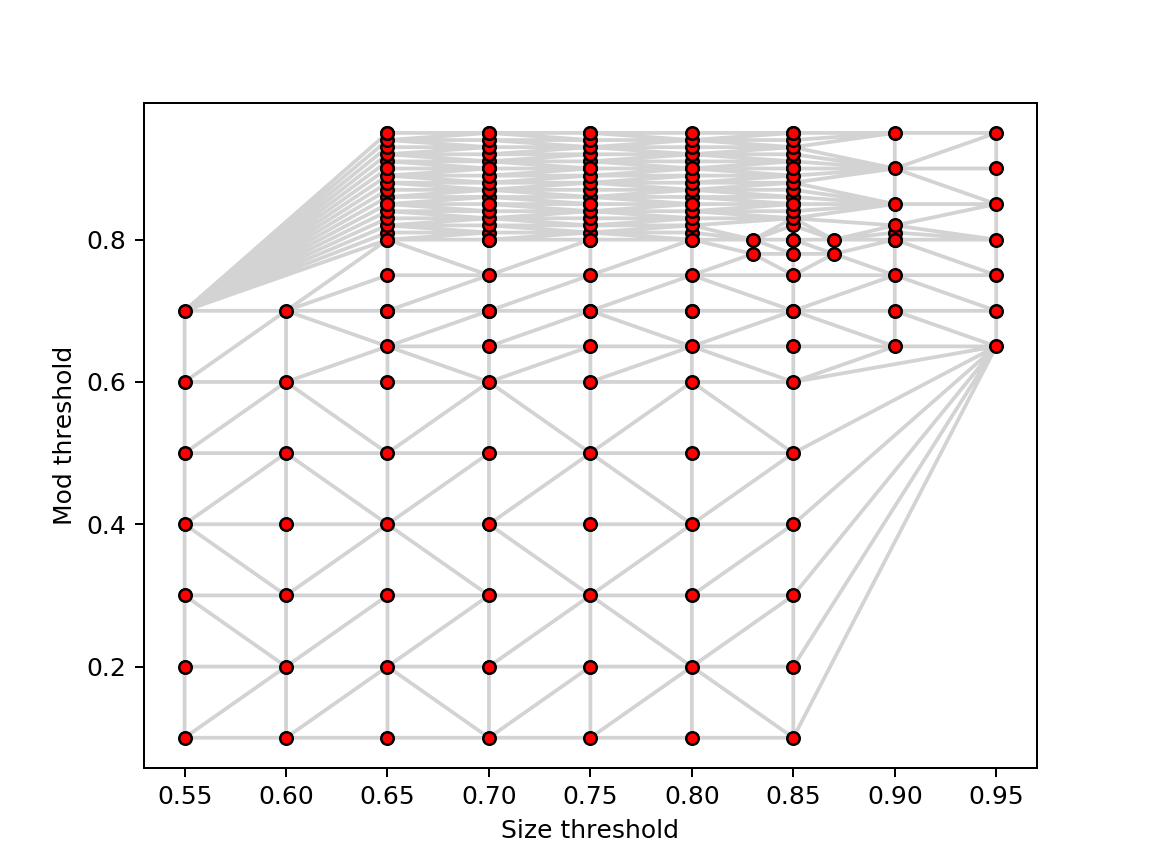

In [55]:
triang = mtri.Triangulation(x, y)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.triplot(triang, c="#D3D3D3", marker='.', markerfacecolor="r", markeredgecolor="black", markersize=10)
ax.set_xlabel('Size threshold')
ax.set_ylabel('Mod threshold')
plt.show()

<IPython.core.display.Javascript object>


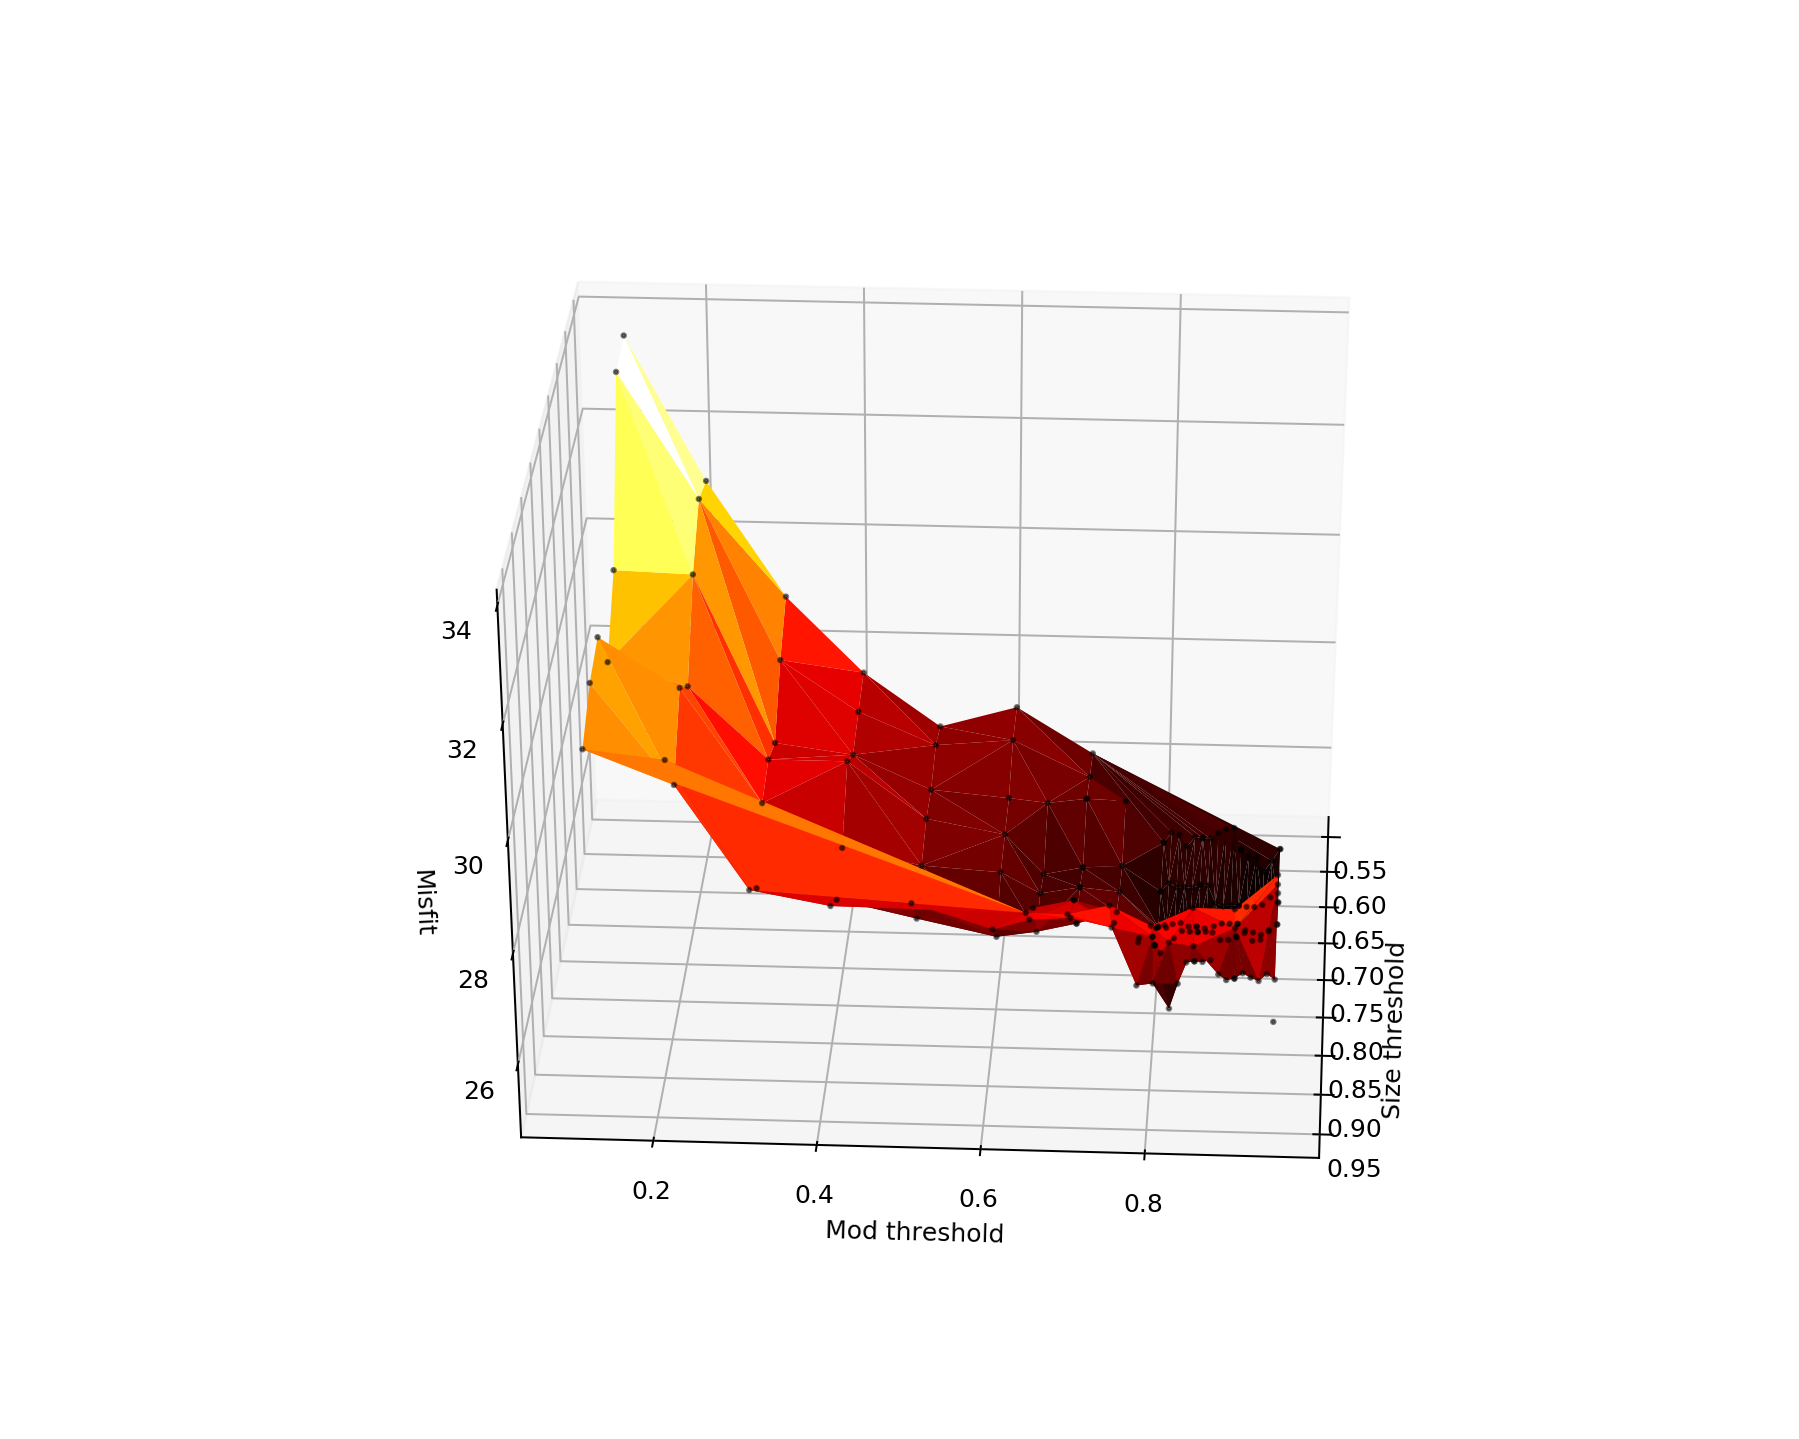

In [56]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.plot_trisurf(triang, z, cmap='hot')
ax.scatter(x,y,z, marker='.', s=10, c="black", alpha=0.5)
ax.view_init(elev=20, azim=45)

ax.set_xlabel('Size threshold')
ax.set_ylabel('Mod threshold')
ax.set_zlabel('Misfit')
plt.show()

## Cross-validation